In [1]:
import os

import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

import isodate
import datetime

import re

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
scopes = ["https://www.googleapis.com/auth/youtube.readonly"]
#           "https://www.googleapis.com/auth/youtubepartner-channel-audit",
#           "https://www.googleapis.com/auth/youtubepartner"]

os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

api_service_name = "youtube"
api_version = "v3"
client_secrets_file = "my_client_desktop.json"
channel_id = 'UCQIRSud94PUpBjMIjM_wgiA'
# channel_id = 'UC0MpTTqWtX6xUFR8Ee4Vd6A' # Айсена Андреева (Канал Алексея)
# channel_id = 'UC9wpw9wWC-8kCs4ho7Uiptw' # Id Айсена Антонова

In [4]:
flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(
        client_secrets_file, scopes)
credentials = flow.run_console()
youtube = googleapiclient.discovery.build(
        api_service_name, api_version, credentials=credentials)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=543654904839-lltmk49hvj2bb11eofgrhemrg2djtv89.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.readonly&state=nKXwbVbbPgqaqTsBvoUgwKOFByyRLD&prompt=consent&access_type=offline
Enter the authorization code: 4/1AfJohXkwdWWQhwg0IuyqDfYhGXVVb1A2u4mgs8LScGEC6V1te57RvHgrbGk


## Функция для получения статистики о канале

In [5]:
def get_channel_stats(youtube, channel_id):
    
    request = youtube.channels().list(
            part='snippet,contentDetails,statistics',
            id=channel_id)
    response = request.execute()
    
    data = dict(Channel_name = response['items'][0]['snippet']['title'],
                Subscribers = response['items'][0]['statistics']['subscriberCount'],
                Description = response['items'][0]['snippet']['description'],
                Views = response['items'][0]['statistics']['viewCount'],
                Total_videos = response['items'][0]['statistics']['videoCount'])
    
    return data

In [6]:
channel_statistics = get_channel_stats(youtube, channel_id)
channel_data = pd.DataFrame(channel_statistics, index=[0])
# channel_data

## Функция для получения статистики о понравившихся видео (Алгоритмы YouTube)

In [7]:
def get_my_liked_videos_stats(youtube):
    all_data = []
    nextPageToken = None
    for i in range(1, 40):  # 40 Потому что больше 2000 данных будет избыточно.
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics,player",
            myRating="like",
            maxResults=50,
            pageToken=nextPageToken
        )
        
        response = request.execute()
        
        for i in range(len(response['items'])):
            data = dict(PublishedAt = response['items'][i]['snippet']['publishedAt'],
                        ChannelId = response['items'][i]['snippet']['channelId'],
                        Title = response['items'][i]['snippet']['title'],
                        Tags = response['items'][i]['snippet'].get('tags'),
                        Kind = response['items'][i]['kind'],
                        Description = response['items'][i]['snippet']['description'],
                        ChannelTitle = response['items'][i]['snippet']['channelTitle'],
                        Id_video_category = response['items'][i]['snippet']['categoryId'],
                        liveBroadcastContent = response['items'][i]['snippet']['liveBroadcastContent'],
                        Duration = response['items'][i]['contentDetails']['duration'],
                        ViewCount = response['items'][i]['statistics'].get('viewCount'),
                        LikeCount = response['items'][i]['statistics'].get('likeCount'),
                        )
            all_data.append(data)
        
        nextPageToken = response.get('nextPageToken')
        if not nextPageToken: 
            break
    
    return all_data

In [8]:
my_liked_videos_stats = get_my_liked_videos_stats(youtube)
my_liked_videos_data = pd.DataFrame(my_liked_videos_stats)
# my_liked_videos_data

## Функция для получения RU категорий на YouTube

In [9]:
def get_video_categories(youtube):
    all_data = []
    request = youtube.videoCategories().list(
        part="snippet",
        hl="RU",
        regionCode="RU"
    )
    response = request.execute()

    for i in range(len(response['items'])):
        data = dict(Id_video_category = response['items'][i]['id'],
                    Category = response['items'][i]['snippet']['title'],
                    Assignable = response['items'][i]['snippet']['assignable'], # Имеет ли возможность иметь несколько категорий
                    )
        all_data.append(data)
    return all_data

In [10]:
video_categories = get_video_categories(youtube)
video_categories_data = pd.DataFrame(video_categories)
# video_categories_data

## Функция для получения статистики о подписках

In [11]:
def get_subscriptions_stats(youtube, channel_id):
    all_data = []
    nextPageToken = None
    for i in range(1, 20):  # 20 Потому что больше 1000 данных будет избыточно.
        request = youtube.subscriptions().list(
            part="snippet,contentDetails,subscriberSnippet,id",
            channelId=channel_id,
            maxResults=50,
            pageToken=nextPageToken
        )
        
        response = request.execute()
        
        for i in range(len(response['items'])):
            data = dict(Channel_name = response['items'][i]['snippet']['title'],
                        Description = response['items'][i]['snippet']['description'],
                        Subscription_time = response['items'][i]['snippet']['publishedAt'],
                        ChannelId = response['items'][i]['snippet']['resourceId']['channelId'])
            all_data.append(data)
        
        nextPageToken = response.get('nextPageToken')
        if not nextPageToken: 
            break
    
    return all_data

In [12]:
subscriptions_stats = get_subscriptions_stats(youtube, channel_id)
subscriptions_stats_data = pd.DataFrame(subscriptions_stats)
# subscriptions_stats_data

## Функция для получения статистики об активностях

In [13]:
def get_activities_stats(youtube, channel_id):
    all_data = []
    nextPageToken = None
    for i in range(1, 20):  # 20 Потому что больше 1000 данных будет избыточно.
        request = youtube.activities().list(
            part="snippet,contentDetails",
            channelId=channel_id,
            maxResults=50,
            pageToken=nextPageToken
        )
        
        response = request.execute()
        
        for i in range(len(response['items'])):
            data = dict(Date = response['items'][i]['snippet']['publishedAt'],
                    Channel_name = response['items'][i]['snippet']['channelTitle'],
                    type = response['items'][i]['snippet']['type'])
            all_data.append(data)
        
        nextPageToken = response.get('nextPageToken')
        if not nextPageToken: 
            break
    
    return all_data

In [14]:
activities_statistics = get_activities_stats(youtube, channel_id)
activities_data = pd.DataFrame(activities_statistics)
# activities_data

## Аналитика данных

Читаем файл video_categories_weights с весами.

In [15]:
video_categories_weights = pd.read_excel('video_categories.xlsx')
# video_categories_weights

Приведение типов с object на int для того, чтобы можно было посмотреть данные и обучить модель

In [16]:
video_categories_weights['Id_video_category'] = video_categories_weights['Id_video_category'].astype(int)
my_liked_videos_data['Id_video_category'] = my_liked_videos_data['Id_video_category'].astype(int)
df = my_liked_videos_data.merge(video_categories_weights, left_on='Id_video_category', right_on="Id_video_category")

## Фильтр данных и предобработка реальных данных

Сейчас мы будем фильтровать видео длиной менее 1 минуты и более 200 минут. 

Также мы уберем цифры и оставим только символы от а до я и от a до z. 

Также весь текст мы сделаеи нижнем регистре. Еще убираем пустые строки и между словами делаем чтобы был 1 пробел.

In [17]:
df

,PublishedAt,ChannelId,Title,Tags,Kind,Description,ChannelTitle,Id_video_category,liveBroadcastContent,Duration,ViewCount,LikeCount,Category,Weight
0,2020-08-18T08:38:25Z,UC4zWkr8wesB2-qliEayfMxw,Многоклассовая классификация текста на Python,"[python, NLP, NLTK, sklearn, анализ текста, кл...",youtube#video,Исходный код скрипта - https://github.com/Meta...,Айрат Галямов,22,none,PT53M41S,8117,230,Люди и блоги,0.10
1,2023-10-01T18:59:03Z,UC3u7hWQJojXuh5JY1jLUNPQ,Senior Разработчик в 19 лет,[Sгур],youtube#video,Сегодня у нас в гостях Саша – крутой человек c...,SГур,22,none,PT40M55S,23539,1283,Люди и блоги,0.10
2,2023-10-13T08:09:07Z,UCtCqaM3LNyyJVViZDWn-gFQ,А как бы вы оценили этот фильм?,None,youtube#video,,Мастер Бизнеса,22,none,PT51S,2750037,110648,Люди и блоги,0.10
3,2023-12-08T18:06:57Z,UCYIZq5bdY3XKKguiu0Xa8Sg,"Он брал задание на рубку дров, и там удивил вс...",None,youtube#video,,Dezom Anime,22,none,PT1M,1341909,None,Люди и блоги,0.10
4,2023-09-20T14:28:09Z,UC5CzMNn6Qhm8Ms1W1UUlQYQ,ПРИВЫЧКИ МОЕГО МУЖА-ЯПОНЦА: перфекционист..,None,youtube#video,,Madina Miyake,22,none,PT1M1S,813396,64058,Люди и блоги,0.10
5,2023-11-26T12:27:47Z,UC-kuIJAUVifVo2DkzbOZ9ug,"ВИДЕОКАРТЫ ""НЕ С МАЙНИНГА""! Как они получаются...",None,youtube#video,,ANDMINING,22,none,PT37S,728598,41226,Люди и блоги,0.10
6,2022-12-07T08:16:12Z,UCuq6VZoQMNhNy6JIhJh-zWQ,как мы выиграли хакатон веб-дизайнеров | itLand,None,youtube#video,Полная презентация\nhttps://youtu.be/vkLbMyzJr...,Design Kudry,22,none,PT23M8S,931,69,Люди и блоги,0.10
7,2023-12-11T05:00:31Z,UC7vgoI5o3Eik81K6nwd1_eQ,Негибкий мозг программиста старше 35,"[программирование, программист, python, как ст...",youtube#video,"Говорят, что с определенного возраста мозг чел...",Миша Ларченко,22,none,PT6M50S,11728,729,Люди и блоги,0.10
8,2022-02-04T14:02:33Z,UCQV8M_KmhuIGozpYutMTftg,Как Проходит Учеба на Программиста? Итоги Семе...,"[полинилли, polinilly, пермь, санкт петербург,...",youtube#video,"Посмотри предыдущее видео, чтобы следить за эт...",Polinilly,22,none,PT17M23S,18218,518,Люди и блоги,0.10
9,2023-11-06T20:18:00Z,UCEdfUcKSzCMiRBITiHk6TSA,Фэйя Цзоу - актёрская видеовизитка,None,youtube#video,,Feiya Zou,22,none,PT55S,23498,2520,Люди и блоги,0.10


In [18]:
# Мы здесь проходимся по циклу 5 раз. можно 1 раз.

df['total_seconds'] = df['Duration'].apply(isodate.parse_duration)

interval_min = np.timedelta64(1, 'm')
interval_max = np.timedelta64(200, 'm')
filtered_dataset = df[(df['total_seconds'] > interval_min) & (df['total_seconds'] < interval_max)]

filtered_dataset.loc[:, 'Title'] = filtered_dataset.loc[:, 'Title'].str.lower()
filtered_dataset.loc[:, 'Title'] = filtered_dataset.loc[:, 'Title'].str.replace('\d+', '', regex=True)
filtered_dataset.loc[:, 'Title'] = filtered_dataset.loc[:, 'Title'].str.replace('[^а-яА-Яa-zA-Z\s]', '', regex=True)

In [19]:
filtered_dataset

,PublishedAt,ChannelId,Title,Tags,Kind,Description,ChannelTitle,Id_video_category,liveBroadcastContent,Duration,ViewCount,LikeCount,Category,Weight,total_seconds
0,2020-08-18T08:38:25Z,UC4zWkr8wesB2-qliEayfMxw,многоклассовая классификация текста на python,"[python, NLP, NLTK, sklearn, анализ текста, кл...",youtube#video,Исходный код скрипта - https://github.com/Meta...,Айрат Галямов,22,none,PT53M41S,8117,230,Люди и блоги,0.10,0 days 00:53:41
1,2023-10-01T18:59:03Z,UC3u7hWQJojXuh5JY1jLUNPQ,senior разработчик в лет,[Sгур],youtube#video,Сегодня у нас в гостях Саша – крутой человек c...,SГур,22,none,PT40M55S,23539,1283,Люди и блоги,0.10,0 days 00:40:55
4,2023-09-20T14:28:09Z,UC5CzMNn6Qhm8Ms1W1UUlQYQ,привычки моего мужаяпонца перфекционист,None,youtube#video,,Madina Miyake,22,none,PT1M1S,813396,64058,Люди и блоги,0.10,0 days 00:01:01
6,2022-12-07T08:16:12Z,UCuq6VZoQMNhNy6JIhJh-zWQ,как мы выиграли хакатон вебдизайнеров itland,None,youtube#video,Полная презентация\nhttps://youtu.be/vkLbMyzJr...,Design Kudry,22,none,PT23M8S,931,69,Люди и блоги,0.10,0 days 00:23:08
7,2023-12-11T05:00:31Z,UC7vgoI5o3Eik81K6nwd1_eQ,негибкий мозг программиста старше,"[программирование, программист, python, как ст...",youtube#video,"Говорят, что с определенного возраста мозг чел...",Миша Ларченко,22,none,PT6M50S,11728,729,Люди и блоги,0.10,0 days 00:06:50
8,2022-02-04T14:02:33Z,UCQV8M_KmhuIGozpYutMTftg,как проходит учеба на программиста итоги семес...,"[полинилли, polinilly, пермь, санкт петербург,...",youtube#video,"Посмотри предыдущее видео, чтобы следить за эт...",Polinilly,22,none,PT17M23S,18218,518,Люди и блоги,0.10,0 days 00:17:23
12,2023-11-21T12:49:33Z,UC5CzMNn6Qhm8Ms1W1UUlQYQ,правила брака с японцем привычки туалета,None,youtube#video,,Madina Miyake,22,none,PT1M1S,34516213,1215219,Люди и блоги,0.10,0 days 00:01:01
13,2023-03-24T14:30:05Z,UCjt03M3ibGi8aojJEenQf6Q,поступление и учеба на программиста моя истор...,"[учеба, поступлениевуниверситет, университет, ...",youtube#video,"Хэй! Рада видеть тебя в этом видео и надеюсь, ...",Xencha Jewell,22,none,PT17M34S,9102,326,Люди и блоги,0.10,0 days 00:17:34
14,2022-01-22T16:31:46Z,UCJQJAI7IjbLcpsjWdSzYz0Q,youtube api for python how to create a unique ...,"[data analytics, data science, python, data, t...",youtube#video,👩🏻‍💻 My laptop and iPad for doing DS/ study 👉 ...,Thu Vu data analytics,22,none,PT22M33S,58550,2715,Люди и блоги,0.10,0 days 00:22:33
15,2023-06-07T16:53:05Z,UCXqBsOh-QPqSgRJctCzNoXQ,как бы я изучал программирование если бы мог н...,"[как стать программистом, программирование с н...",youtube#video,✈️ Подписывайся на мой Телеграм - https://t.me...,AROKEN,22,none,PT16M31S,246944,13386,Люди и блоги,0.10,0 days 00:16:31


## Инфографика по категориям

In [20]:
df_c = filtered_dataset[['Category', 'LikeCount']].groupby(['Category']).count().sort_values(by='LikeCount', ascending=False).reset_index()
df_c = df_c.head(10)

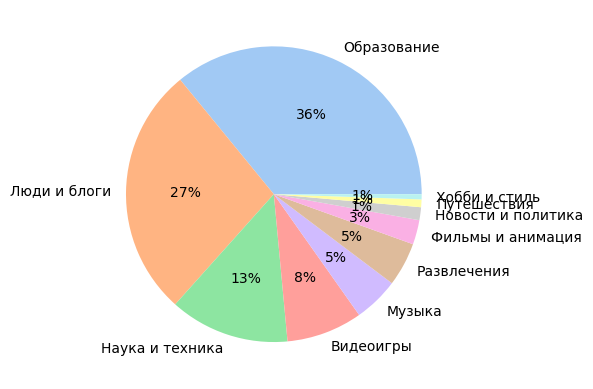

In [21]:
colors = sns.color_palette('pastel')

plt.pie(df_c['LikeCount'], labels = df_c['Category'], colors = colors, autopct='%.0f%%')
plt.show()

In [22]:
result = df_c

## Статистика по кол-ву тэгов и инфографика по тэгам

In [23]:
res = [item for sublist in filtered_dataset['Tags'] if sublist is not None for item in sublist]

Здесь идет предобработка данных.

Мы уберем цифры и оставим только символы от а до я и от a до z. 

Также весь текст мы сделаеи нижнем регистре. Еще убираем пустые строки и между словами делаем чтобы был 1 пробел.

In [24]:
res = [x.lower() for x in res]
res = [re.sub('\d+', '', x) for x in res]
res = [re.sub('[^а-яА-Яa-zA-Z\s]', '', x) for x in res]
res = [x.strip() for x in res]
res = [x for x in res if x.strip() != '']

Результат работы

In [25]:
res

['python',
 'nlp',
 'nltk',
 'sklearn',
 'анализ текста',
 'классификация',
 'sгур',
 'программирование',
 'программист',
 'python',
 'как стать программистом',
 'разработка',
 'java',
 'javascript',
 'джава',
 'юмор',
 'linux',
 'разработчик',
 'php',
 'c',
 'вся правда',
 'какой язык программирования выбрать',
 'видеокарта',
 'уроки',
 'айти',
 'для новичков',
 'новичку',
 'фриланс',
 'ноутбук для программиста',
 'компьютер для программиста',
 'программирование с нуля',
 'для начинающих',
 'компьютер',
 'rust',
 'c',
 'языки программирования',
 'язык',
 'основы',
 'ассемблер',
 'go',
 'с чего начать',
 'windows',
 'создание игр',
 'полинилли',
 'polinilly',
 'пермь',
 'санкт петербург',
 'петербург',
 'питер',
 'переезд',
 'итмо',
 'студент',
 'учеба',
 'общежитие',
 'университет',
 'поступление',
 'общага',
 'эстетика',
 'атмосфера',
 'study with me',
 'итоги года',
 'итоги семестра',
 'конец семестра',
 'сессия',
 'как пережить сессию',
 'сдаю сессию',
 'впервые отличница',
 'курс'

Здесь мы считаем сколько всего каких тэгов. Например как много таких или иных тэгов

In [26]:
tag_counts = {}
for tag in res:
    tag_counts[tag] = tag_counts.get(tag, 0) + 1
    
sorted_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)
top_tags = sorted_tags[:50]

Инфографика тэгов

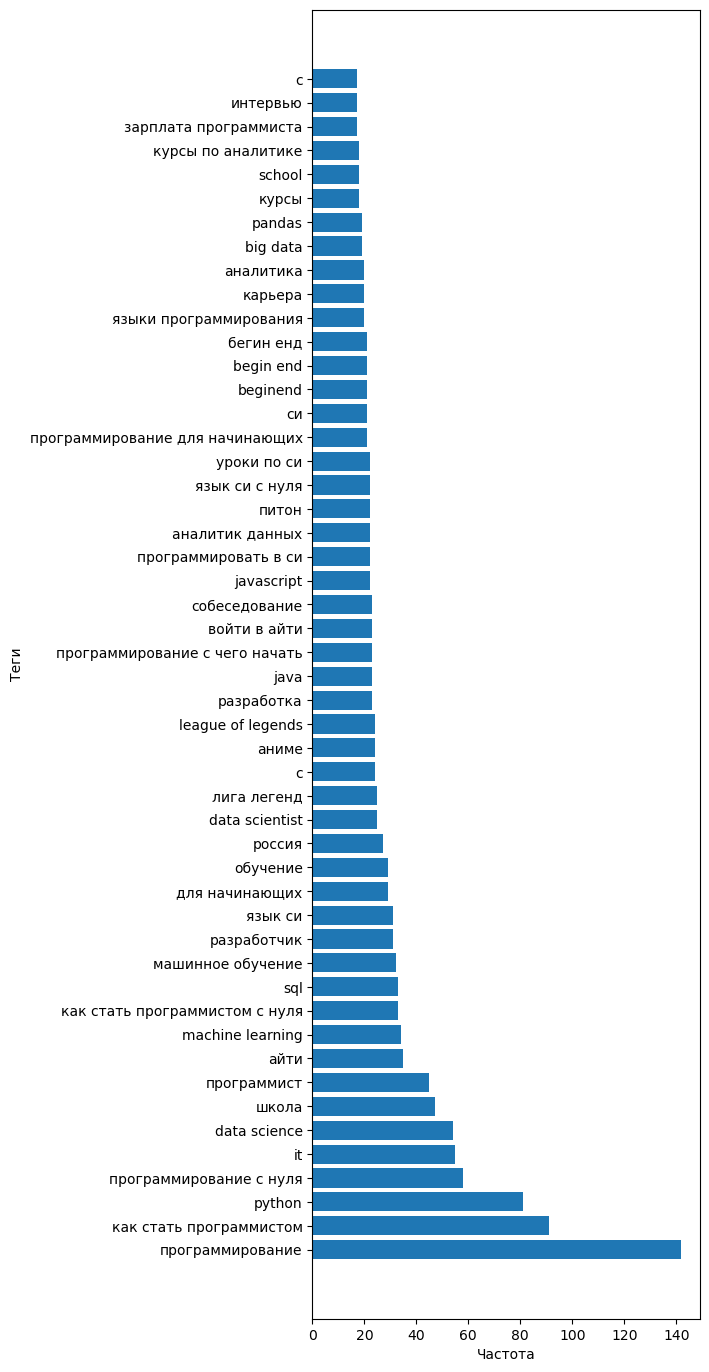

In [27]:
tags, freq = zip(*top_tags)
fig, ax = plt.subplots()

ax.barh(tags, freq)
ax.set_ylabel('Теги')
ax.set_xlabel('Частота')
fig.set_size_inches(5, 17)

plt.show()

In [28]:
result2 = top_tags

## Обучение модели по тэгам

Читаем наш датасет

In [29]:
tag_dataset = pd.read_excel('dataset.xlsx')

Предобработка данных. Снова убираем цифры, делаем нижний регистр, пустые строки убираем и тд.

Убираем кол-во профессий которое меньше 5.

In [30]:
tag_dataset['Tag'] = tag_dataset['Tag'].astype(str)
tag_dataset['Profession'] = tag_dataset['Profession'].astype(str)

tag_dataset.loc[:, 'Tag'] = tag_dataset.loc[:, 'Tag'].str.lower()
tag_dataset.loc[:, 'Tag'] = tag_dataset.loc[:, 'Tag'].str.replace('\d+', '', regex=True)
tag_dataset.loc[:, 'Tag'] = tag_dataset.loc[:, 'Tag'].str.replace('[^а-яА-Яa-zA-Z\s]', '', regex=True)
tag_dataset.loc[:, 'Tag'] = tag_dataset.loc[:, 'Tag'].str.strip()
tag_dataset.loc[:, 'Tag'] = tag_dataset.loc[tag_dataset['Tag'] != '']

data_dataset = tag_dataset.groupby(by='Profession').filter(lambda x: len(x['Tag']) >= 10)

Так выглядит наш датасет

In [31]:
data_dataset.groupby(by='Profession').count().sort_values(by='Tag')

,Tag
Profession,
Спортсмен,10
Экономист,10
Автомеханик,11
Художник-аниматор,11
Аниматор,12
Повар,15
Рэпер,18
Разработчик игр,18
Ведущий,18


Мы видим, что некоторых профессий мало, то есть 5. Нам нужно немного сбланасировать классы для того, чтобы модель точнее предсказывала такие прфоессии.

In [32]:
# Определение редких профессий
rare_professions_df = data_dataset.groupby(by='Profession').count().sort_values(by='Tag') < 25
rare_professions_list = rare_professions_df.index[rare_professions_df['Tag']].tolist()

In [33]:
rare_samples = data_dataset[data_dataset['Profession'].isin(rare_professions_list)]
duplicated_samples = rare_samples.sample(n=1000, replace=True)
oversampled_df = pd.concat([data_dataset, duplicated_samples], ignore_index=True)

In [34]:
oversampled_df.groupby(by='Profession').count().sort_values(by='Tag')

,Tag
Profession,
Режиссер,25
Ютубер,29
Музыкант,29
Блогер,31
Актер,34
Аналитик данных,34
Телеведущий,42
Комик,45
Спортсмен,54


In [35]:
# Создание признаков и целевой переменной
y = oversampled_df['Profession']
X = oversampled_df['Tag']

In [37]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=7)

In [38]:
# Преобразование текстовых данных в числовые с помощью BoW (мешок слов)
X_train = np.where(pd.isna(X_train), '', X_train)
X_test = np.where(pd.isna(X_test), '', X_test)

vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [39]:
X_train

array(['стендап', 'михаил делягин', 'рецепты', ..., 'федук', 'анимация',
       'iphone'], dtype=object)

In [40]:
# Обучение модели CatBoost
model = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.1,
    random_seed=21,
)
model.fit(
    X_train_bow, y_train,
    verbose=False,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [180]:
# Классификация текстов
y_pred = model.predict(X_test_bow)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8152173913043478


In [181]:
model.save_model('catboost_model.bin')

In [182]:
y_pred_df = pd.DataFrame({'Profession': y_pred.flatten()})

In [183]:
profession_counts = y_pred_df['Profession'].value_counts()
profession_counts = profession_counts[profession_counts.index != 'nan']

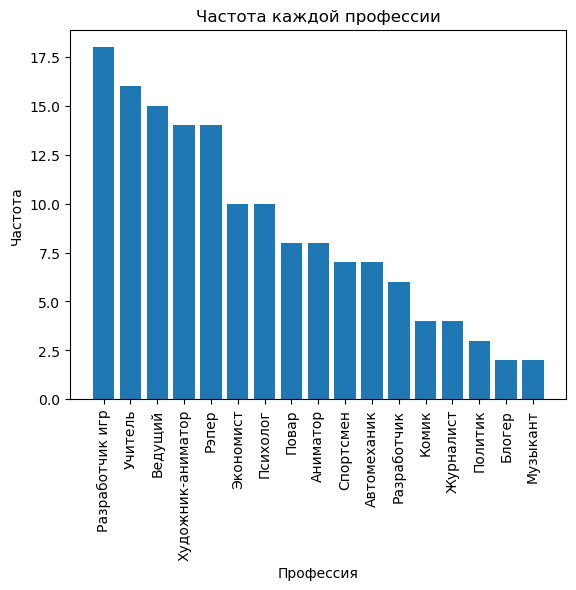

In [184]:
plt.bar(profession_counts.index, profession_counts.values)
plt.xlabel('Профессия')
plt.ylabel('Частота')
plt.title('Частота каждой профессии')
plt.xticks(rotation=90)  # Поворот значений по оси X
plt.show()

## Использование реальных данных

In [219]:
# Загрузка модели
model = CatBoostClassifier()
model.load_model('catboost_model.bin')

In [220]:
# Загрузка данных
df = pd.DataFrame(res)
df = df.rename(columns={0: 'Tag'})
df['Tag'] = df['Tag'].astype(str)

In [221]:
text_array = df['Tag'].values.astype(str)
arr_obj = text_array.astype(object)

In [224]:
# Преобразование текстовых данных в числовые с помощью BoW (мешок слов)
vectorizer = CountVectorizer()
X_train_bow = vectorizer.transform(arr_obj)

NotFittedError: Vocabulary not fitted or provided

In [189]:
predictions = model.predict(X_train_bow)

In [190]:
result3 = pd.DataFrame(predictions)

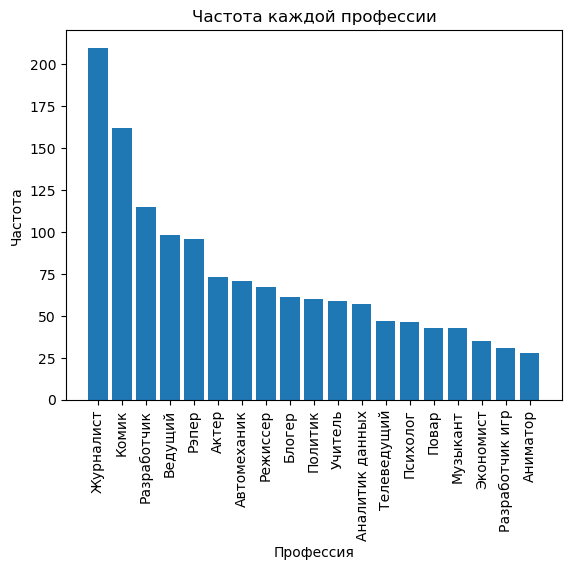

In [191]:
y_pred_df = pd.DataFrame({'Profession': predictions.flatten()})
profession_counts = y_pred_df['Profession'].value_counts().head(20)
profession_counts = profession_counts[profession_counts.index != 'nan']
plt.bar(profession_counts.index, profession_counts.values)
plt.xlabel('Профессия')
plt.ylabel('Частота')
plt.title('Частота каждой профессии')
plt.xticks(rotation=90)  # Поворот значений по оси X
plt.show()

## Обучение модели по названием видео (Плохо работает)

In [192]:
mean_video = filtered_dataset['total_seconds'].mean()
filtered_dataset['weight_to_model'] = (filtered_dataset['total_seconds'] * filtered_dataset['Weight'] / mean_video)

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_14324\1365410757.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataset['weight_to_model'] = (filtered_dataset['total_seconds'] * filtered_dataset['Weight'] / mean_video)


In [193]:
new_model = filtered_dataset[['weight_to_model', 'ChannelTitle', 'Category', 'Title']]

In [194]:
new_model_new = pd.read_excel('new_model_new_xxx.xlsx', sheet_name='model2')

## Предобработка данных

In [195]:
new_model_new['Title'] = new_model_new['Title'].str.lower()
new_model_new['Title'] = new_model_new['Title'].str.replace('\d+', '', regex=True)
new_model_new['Title'] = new_model_new['Title'].str.replace('[^а-яА-Яa-zA-Z\s]', '', regex=True)

In [196]:
new_model_new

,weight_to_model,ChannelTitle,Category,Title,Profession
0,1.0,NaN,NaN,смарт тв не видит интернет как подключить тел...,Android-разработчик
1,1.0,NaN,NaN,что учить новичку в android java vs kotlin моб...,Android-разработчик
2,1.0,NaN,NaN,как стать androidразработчиком в году,Android-разработчик
3,1.0,NaN,NaN,уроки android studio с нуля разработка андр...,Android-разработчик
4,1.0,NaN,NaN,уроки android studio с нуля интерфеис прогр...,Android-разработчик
5,1.0,NaN,NaN,уроки android studio с нуля написание кода ...,Android-разработчик
6,1.0,NaN,NaN,уроки android studio с нуля всплывающие соо...,Android-разработчик
7,1.0,NaN,NaN,уроки android studio с нуля переход между с...,Android-разработчик
8,1.0,NaN,NaN,чем занимается android разработчик требования ...,Android-разработчик
9,1.0,NaN,NaN,java,Android-разработчик


In [197]:
new_model_new.groupby(by='Profession').count().sort_values(by='Title')

,weight_to_model,ChannelTitle,Category,Title
Profession,,,,
Android-разработчик,49,0,0,49
Backend-разработчик,50,0,0,50
DevOps инженер,50,0,0,50
Frontend-разработчик,50,0,0,50
ML Разработчик,50,0,0,50
Swift-разработчик,50,0,0,50
UI/UX дизайнер,50,0,0,50
Бизнес-аналитик/Системный аналитик/Аналитик данных,50,0,0,50
Разработчик ПО,50,0,0,50


In [198]:
new_model_new['Title'] = new_model_new['Title'].astype(str)
new_model_new['Profession'] = new_model_new['Profession'].astype(str)
new_model_new['weight_to_model'] = new_model_new['weight_to_model'].astype(float)

In [199]:
new_model_new.dtypes

weight_to_model    float64
ChannelTitle       float64
Category           float64
Title               object
Profession          object
dtype: object

In [200]:
# Создание признаков и целевой переменной
YY = new_model_new['Profession']
XX = new_model_new['Title']
WW = new_model_new['weight_to_model']

In [201]:
# Разделение данных на обучающую и тестовую выборки
XX_train, XX_test, yy_train, yy_test, weights_train, weights_test = train_test_split(XX, YY, WW, test_size=0.1, random_state=21)

In [202]:
# Преобразование текстовых данных в числовые с помощью BoW (мешок слов)
vectorizer = CountVectorizer()
XX_train_bow = vectorizer.fit_transform(XX_train)
XX_test_bow = vectorizer.transform(XX_test)

In [203]:
# Обучение модели CatBoost
model2 = CatBoostClassifier(
    iterations=3000, 
    random_state=11,
    learning_rate=0.5
)
model2.fit(
    XX_train_bow, yy_train, 
    sample_weight=weights_train,
    plot=True,
    verbose=False
)
# model.fit(XX_train_bow, yy_train)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [204]:
print('Обучена ли модель: ' + str(model.is_fitted()))

Обучена ли модель: True


In [207]:
# Классификация текстов
yy_pred = model2.predict(XX_test_bow)

# Оценка качества модели
accuracy = accuracy_score(yy_test, yy_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7333333333333333


In [210]:
model2.save_model('catboost_model2.bin')

In [208]:
Y_pred_df = pd.DataFrame({'Profession': yy_pred.flatten()})
profession_counts = Y_pred_df['Profession'].value_counts()
# profession_counts = profession_counts[profession_counts.index != 'nan']

Внизу угаданные данные. Мы можем это видеть внизу.

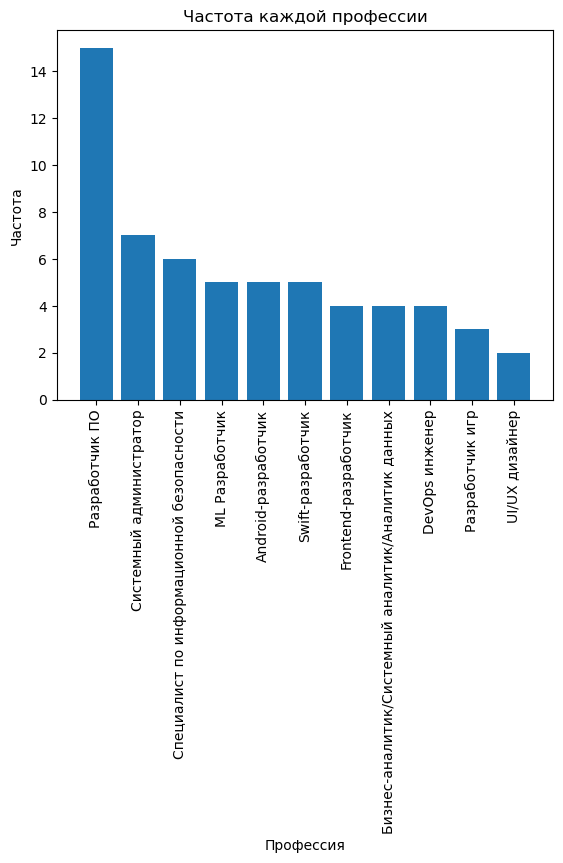

In [209]:
plt.bar(profession_counts.index, profession_counts.values)
plt.xlabel('Профессия')
plt.ylabel('Частота')
plt.title('Частота каждой профессии')
plt.xticks(rotation=90)  # Поворот значений по оси X
plt.show()

## Реальные данные

In [217]:
model2 = CatBoostClassifier()
model2.load_model('catboost_model2.bin')

In [218]:
XX_real

0          многоклассовая классификация текста на python
1                              senior разработчик в  лет
4                привычки моего мужаяпонца перфекционист
6          как мы выиграли хакатон вебдизайнеров  itland
7                     негибкий мозг программиста старше 
8      как проходит учеба на программиста итоги семес...
12              правила брака с японцем привычки туалета
13     поступление и учеба на программиста  моя истор...
14     youtube api for python how to create a unique ...
15     как бы я изучал программирование если бы мог н...
16     что я понял за  лет в it зарплата где учиться ...
17               проблемы с девушками в программировании
18        go vs nodejs плюсы и минусы что лучше выбрать 
19                   что не так с электронными ценниками
20                       учился программировать все лето
21     почему вы никогда не найдете дата саентиста  в...
22     фейлы на соревнованиях по машинному обучению  ...
23     как я стала программисто

In [215]:
XX_real = filtered_dataset['Title']
XX_real_bow = vectorizer.transform(XX_real)
user_pred2 = model2.predict(XX_real_bow)

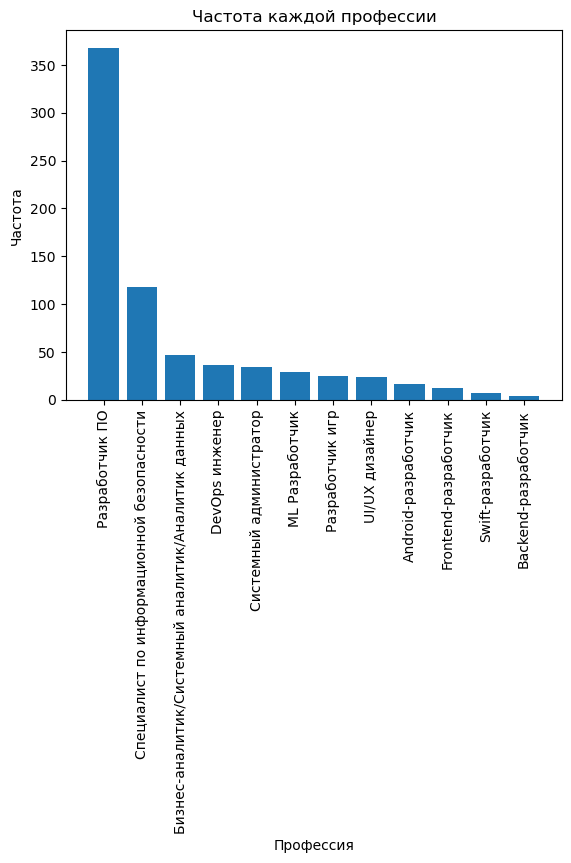

In [216]:
y_prediction_df = pd.DataFrame({'Profession': user_pred2.flatten()})
profession_counts = y_prediction_df['Profession'].value_counts()
profession_counts = profession_counts[profession_counts.index != 'nan']
plt.bar(profession_counts.index, profession_counts.values)
plt.xlabel('Профессия')
plt.ylabel('Частота')
plt.title('Частота каждой профессии')
plt.xticks(rotation=90)  # Поворот значений по оси X
plt.show()